<a href="https://colab.research.google.com/github/nsprabha/neurological_disorder/blob/main/didiget.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls /content/drive/MyDrive/dataset/

archive-mridataset.zip


In [3]:
import zipfile

zip_path = "/content/drive/MyDrive/dataset/archive-mridataset.zip"
extract_path = "/content/mri_dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction complete!")


Extraction complete!


In [4]:
!pip install torch torchvision pennylane matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 567.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 63.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 61.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import pennylane as qml
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

# Dataset Path
dataset_path = "/content/mri_dataset"  # Change to your dataset

# Image Transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Load Dataset
full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Training size: {len(train_dataset)}, Testing size: {len(test_dataset)}")

# =========================================================
# ✅ Define Quantum Circuit (Fixed Version)
# =========================================================
n_qubits = 8  # Number of qubits
n_layers = 6  # Quantum layers

dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="torch")
def quantum_circuit(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))  # Data encoding
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))  # Quantum processing
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]  # Output expectation values


# =========================================================
# ✅ Define Hybrid CNN + QNN Model (Fixed)
# =========================================================
class HybridQNN(nn.Module):
    def __init__(self):
        super(HybridQNN, self).__init__()

        # CNN Layers
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 8 * 8, n_qubits)  # Output matches quantum input size

        # Quantum Layer (Fixed)
        # 🔹 Quantum Layer
        weight_shapes = {"weights": (n_layers, n_qubits)}  # ✅ Fix shape issue
        self.q_layer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)


        # Fully Connected Layer
        self.fc2 = nn.Linear(n_qubits, 4)  # 4 classes (meningioma, glioma, healthy, pituitary)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc1(x)
        x = self.q_layer(x)  # Quantum Layer
        x = self.fc2(x)
        return x

# =========================================================
# ✅ Train & Evaluate Hybrid QNN
# =========================================================
model = HybridQNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
epochs = 30
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")

# Testing
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


Using: cpu
Training size: 5618, Testing size: 1405
Epoch [1/30], Loss: 1.3039
Epoch [2/30], Loss: 1.0995
Epoch [3/30], Loss: 0.9223
Epoch [4/30], Loss: 0.7649
Epoch [5/30], Loss: 0.5932
Epoch [6/30], Loss: 0.4704
Epoch [7/30], Loss: 0.3765
Epoch [8/30], Loss: 0.3201
Epoch [9/30], Loss: 0.2495
Epoch [10/30], Loss: 0.1922
Epoch [11/30], Loss: 0.1576
Epoch [12/30], Loss: 0.1293
Epoch [13/30], Loss: 0.1092
Epoch [14/30], Loss: 0.0900
Epoch [15/30], Loss: 0.0783
Epoch [16/30], Loss: 0.0656
Epoch [17/30], Loss: 0.0583
Epoch [18/30], Loss: 0.0496
Epoch [19/30], Loss: 0.0403
Epoch [20/30], Loss: 0.0376
Epoch [21/30], Loss: 0.0292
Epoch [22/30], Loss: 0.0273
Epoch [23/30], Loss: 0.0222
Epoch [24/30], Loss: 0.0189
Epoch [25/30], Loss: 0.0179
Epoch [26/30], Loss: 0.0204
Epoch [27/30], Loss: 0.0129
Epoch [28/30], Loss: 0.0132
Epoch [29/30], Loss: 0.0095
Epoch [30/30], Loss: 0.0075
Test Accuracy: 94.88%


In [6]:
import torch

# Save the model
torch.save(model.state_dict(), "qnn_model1.pth")
print("Model saved successfully as qnn_model.pth")


Model saved successfully as qnn_model.pth


Saving healthy_t.jpg to healthy_t.jpg


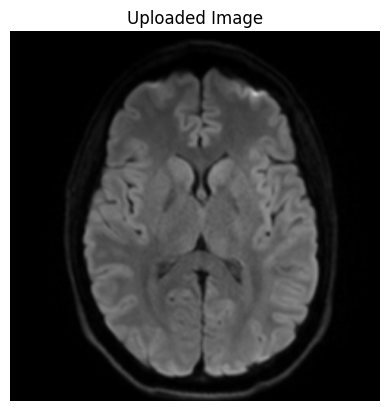

In [10]:
from google.colab import files
from PIL import Image
import matplotlib.pyplot as plt

# Upload an image
uploaded = files.upload()

# Get the filename of the uploaded image
image_path = list(uploaded.keys())[0]

# Display the uploaded image
image = Image.open(image_path)

plt.imshow(image)
plt.axis("off")
plt.title("Uploaded Image")
plt.show()


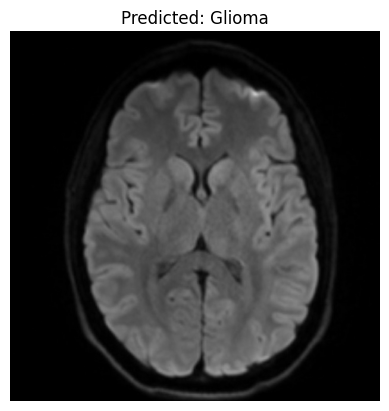

In [11]:
from torchvision import transforms

# Define Preprocessing (Same as Training)
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Convert Image
image_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension

# Run Prediction
with torch.no_grad():
    output = model(image_tensor)
    _, predicted_label = torch.max(output, 1)

# Class Labels (Modify if needed)
class_labels = ["Meningioma", "Glioma", "Healthy", "Pituitary"]
prediction = class_labels[predicted_label.item()]

# Display Prediction
plt.imshow(image)
plt.axis("off")
plt.title(f"Predicted: {prediction}")
plt.show()


In [12]:
#confusion matrix

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


In [13]:
# Set model to evaluation mode
model.eval()

# Initialize lists for true labels and predictions
all_preds = []
all_labels = []

# No gradient calculation needed
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Get model predictions
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # Store labels and predictions
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)


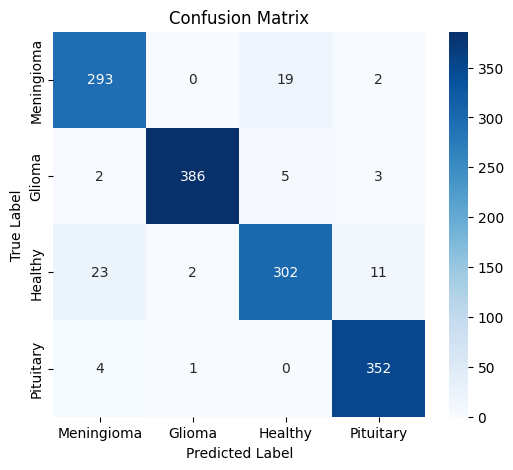

In [14]:
# Define class labels (Ensure they match your dataset)
class_labels = ["Meningioma", "Glioma", "Healthy", "Pituitary"]

# Compute Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [15]:
# Print precision, recall, and F1-score
print("Classification Report:\n", classification_report(all_labels, all_preds, target_names=class_labels))


Classification Report:
               precision    recall  f1-score   support

  Meningioma       0.91      0.93      0.92       314
      Glioma       0.99      0.97      0.98       396
     Healthy       0.93      0.89      0.91       338
   Pituitary       0.96      0.99      0.97       357

    accuracy                           0.95      1405
   macro avg       0.95      0.95      0.95      1405
weighted avg       0.95      0.95      0.95      1405

